# Testing new utility function for MPO

Data imports.

In [114]:
%reload_ext autoreload
%autoreload 2

import rdkit
rdkit.Chem.Draw.IPythonConsole.ipython_maxProperties = -1

import dgym as dg

# load all data
path = '../../dgym-data'

deck = dg.MoleculeCollection.load(
    f'{path}/DSi-Poised_Library_annotated.sdf',
    reactant_names=['reagsmi1', 'reagsmi2', 'reagsmi3']
)

reactions = dg.ReactionCollection.from_json(
    path = f'{path}/All_Rxns_rxn_library_sorted.json',
    smarts_col = 'reaction_string',
    classes_col = 'functional_groups'
)

building_blocks = dg.datasets.disk_loader(f'{path}/Enamine_Building_Blocks_Stock_262336cmpd_20230630.sdf')
fingerprints = dg.datasets.fingerprints(f'{path}/Enamine_Building_Blocks_Stock_262336cmpd_20230630_atoms.fpb')

import torch
import pyarrow.parquet as pq
table = pq.read_table('../../dgym-data/sizes.parquet')[0]
sizes = torch.tensor(table.to_numpy())

In [115]:
from dgym.envs.designer import Designer, Generator

designer = Designer(
    Generator(building_blocks, fingerprints, sizes),
    reactions,
    cache = True
)

In [457]:
from itertools import combinations

num_annotations = 2
paths = [(0,), (1,)]
list(combinations(paths, num_annotations))[0]

((0,), (1,))

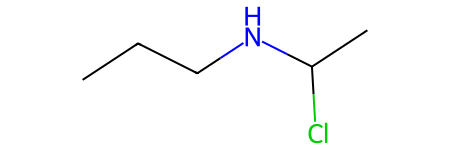

In [845]:
mol[0]

In [937]:
# %%time
from rdkit.Chem.Descriptors import HeavyAtomCount
analog = designer.design(mol[5], strategy='grow')
analog

IndexError: list index out of range

In [1013]:
mol = designer.design(strategy='random')

In [1155]:
mol_drift = []
for _ in range(100):
    mol = designer.design(mol, strategy='replace')[0]
    mol_drift.append(mol)

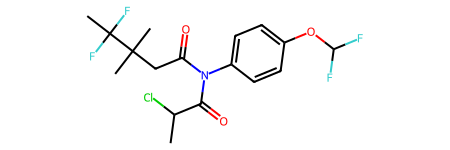

In [1215]:
mol

In [1263]:
routes = [{'reactants': [{'method': 'original', 'product': 'CC(Cl)C(=O)N(C(=O)CC(C)(C)C(C)(F)F)c1ccc(OC(F)F)cc1'}, {'method': 'random', 'size_limit': 10, 'seed': 6414793436848521158}]}]

In [1320]:
routes

[{'reaction': '13_Carboxylate_and_Amine',
  'reactants': [{'method': 'original',
    'product': 'CC(Cl)C(=O)N(C(=O)CC(C)(C)C(C)(F)F)c1ccc(OC(F)F)cc1'},
   {'method': 'random', 'size_limit': 10, 'seed': 2861861246954131022}]}]

In [1283]:
from dgym.utils import OrderedSet

size = 10
products = OrderedSet()
for reaction in reactions:

    if len(products) > size:
        break
    
    routes = [{'reaction': reaction.name, **r} for r in routes]
    analogs = designer.generate_analogs(routes)
    try:
        next(analogs)
        print(reaction.name)
    except:
        pass

    for analog in analogs:

        # Annotate metadata
        analog.inspiration = molecule
        if strategy == 'grow':
            analog.reactants[0] = molecule

        # Collect products
        if len(products) < size:
            products.add(analog)
        else:
            break

[{'reactants': [{'method': 'original', 'product': 'CC(Cl)C(=O)N(C(=O)CC(C)(C)C(C)(F)F)c1ccc(OC(F)F)cc1'}, {'method': 'random', 'size_limit': 10, 'seed': 2433492990412413257}]}]


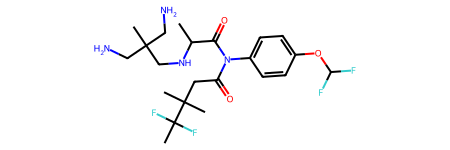

In [1458]:
designer.design(mol, strategy='grow')[0]

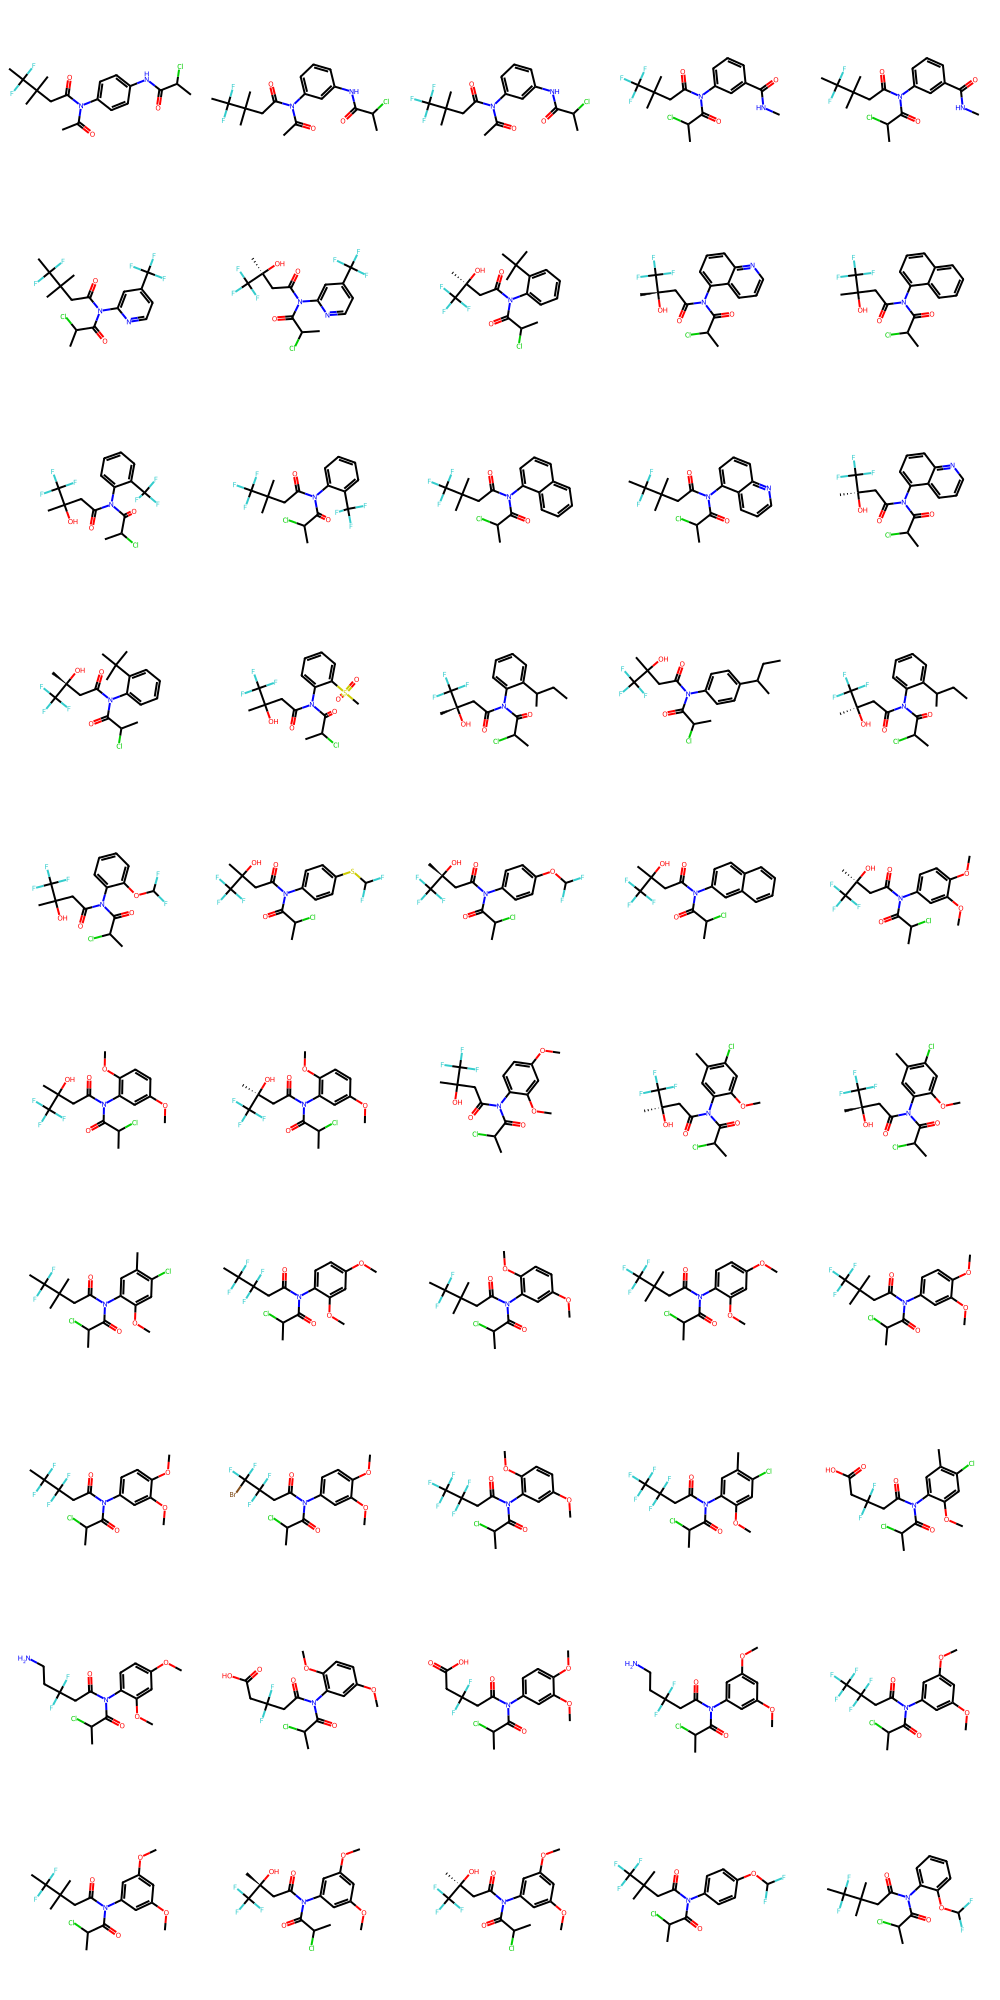

In [1156]:
from rdkit.Chem.Draw import MolsToGridImage

MolsToGridImage(
    [m.mol for m in mol_drift[::2]],
    molsPerRow=5,
)